## Import Packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [2]:
cpu_count = mp.cpu_count()
print(cpu_count)

8


## Define Charset of dataset

In [3]:
data_path = "../data/"

In [4]:
data_names = glob.glob(os.path.join(data_path, "**/*.png"), recursive = True)
print(len(data_names), data_names[0])

2081 ../data\raw_data\226md.png


In [5]:
chars = set(os.path.basename(img).removesuffix(".png") for img in data_names)

letters = sorted(set("".join(chars)))
print(len(letters), letters[:10])

19 ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd']


In [6]:
vocab = ["-"] + letters
print(len(vocab), vocab)

20 ['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [7]:
char_to_idx = {ch:i for i, ch in enumerate(vocab)}
idx_to_char = {i:ch for i, ch in enumerate(vocab)}
print(char_to_idx)
print(idx_to_char)

{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}


## Data Loader

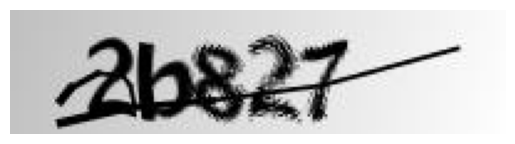

In [116]:
# Visualize data
import matplotlib.pyplot as plt
from PIL import Image

sample_data_path = glob.glob(os.path.join(data_path, "sample/*.png"))[0]
img = Image.open(sample_data_path)

plt.imshow(img)
plt.axis('off')
plt.show()


In [9]:
batch_size = 16
train_data = os.path.join(data_path, "train/")
test_data = os.path.join(data_path, "val/")

In [10]:
os.listdir(train_data)[0]
os.path.dirname(train_data)
len(os.listdir(train_data))

856

In [11]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_path):
        self.data_path = data_path
        
    def __len__(self):
        return len(os.listdir(self.data_path))
    
    def __getitem__(self, index):
        image_fn = os.listdir(self.data_path)[index]
        image_fp = os.path.join(self.data_path, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [12]:
trainset = CAPTCHADataset(train_data) 
testset = CAPTCHADataset(test_data) 

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
print(len(train_loader), len(test_loader))

54 14


In [13]:
len(train_loader)

54

In [14]:
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('dyxnc', '4dw3w', 'd236n', '53wb8', 'fywb8', 'gcx6f', 'be6np', 'cwgyx', 'g7wxw', 'bmxpe', '3mxdn', 'ddcne', '378e5', '57b27', '8bbw8', 'n3bm6')


## Define Model

In [15]:
num_chars = len(char_to_idx)
print(num_chars)
rnn_hidden_size = 256

20


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [17]:
resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [18]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights



class CRNN(nn.Module):
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout

        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
    def forward(self, batch):
        batch = self.cnn_p1(batch)
        batch = self.cnn_p2(batch)
        batch = batch.permute(0, 3, 1, 2)
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1)
        batch = self.linear1(batch)
        batch, _ = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        batch, _ = self.rnn2(batch)
        batch = self.linear2(batch)
        batch = batch.permute(1, 0, 2)
        return batch


In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [71]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [72]:
crnn

CRNN(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [22]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('dyxnc', '4dw3w', 'd236n', '53wb8', 'fywb8', 'gcx6f', 'be6np', 'cwgyx', 'g7wxw', 'bmxpe', '3mxdn', 'ddcne', '378e5', '57b27', '8bbw8', 'n3bm6')
torch.Size([10, 16, 20])


## Define Loss function

In [23]:
criterion = nn.CTCLoss(blank=0)

In [24]:
def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char_to_idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [25]:
def compute_loss(text_batch, text_batch_logits):
    text_batch_logps = F.log_softmax(text_batch_logits, 2) 
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [26]:
compute_loss(text_batch, text_batch_logits)

tensor(4.3346, grad_fn=<MeanBackward0>)

## Train the model

In [73]:
num_epochs = 100
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [74]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

In [75]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [ ]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []

for epoch in tqdm(range(1, num_epochs+1), desc="Epochs"):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    
    for image_batch, text_batch in tqdm(train_loader, desc="Batches", leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print(f"Epoch: {epoch} | Loss: {epoch_loss} | NumUpdates: {num_updates_epoch}")
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)
    current_lr = lr_scheduler.get_last_lr()[0]
    print("Current learning rate:", current_lr)


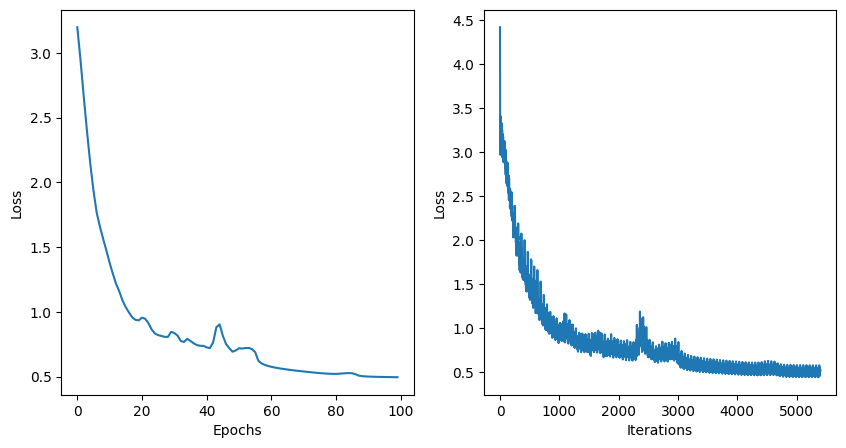

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## Inference

In [78]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx_to_char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [79]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/54 [00:00<?, ?it/s]

In [80]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/14 [00:00<?, ?it/s]

In [81]:
print(results_train.shape)
results_train.head()

(856, 2)


,actual,prediction
0,226md,22-266mmdd
1,22d5n,2--2dd55nn
2,2356g,22335566gg
3,23mdg,2233mmddgg
4,243mm,224433m-mm


In [82]:
print(results_test.shape)
results_test.head()

(214, 2)


,actual,prediction
0,23n88,2233nn8888
1,25w53,2255555533
2,268g2,226688gg22
3,2enf4,22eennff44
4,2fxgd,22ffxxggdd


In [83]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [84]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,226md,22-266mmdd,226md
1,22d5n,2--2dd55nn,22d5n
2,2356g,22335566gg,2356g
3,23mdg,2233mmddgg,23mdg
4,243mm,224433m-mm,243mm


In [85]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,23n88,2233nn8888,23n8
1,25w53,2255555533,253
2,268g2,226688gg22,268g2
3,2enf4,22eennff44,2enf4
4,2fxgd,22ffxxggdd,2fxgd


## Evaluate the model

In [86]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
0,23n88,2233nn8888,23n8
1,25w53,2255555533,253
9,2yggg,22yyggg-gg,2ygg
16,44fyb,4444ffyybb,4fyb
17,44ype,4444yyppee,4ype
19,4d22m,44dd2222mm,4d2m
23,52447,5522444477,5247
30,5nnff,55n--nffff,5nnf
44,6m5eg,66mmmeeegg,6meg
45,6n443,66nn444433,6n43


In [87]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

prediction_corrected
4    37
3     2
5     1
Name: count, dtype: int64


In [88]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected
87,cdcb3,eeddccbb33,edcb3


./data/val/cdcb3.png


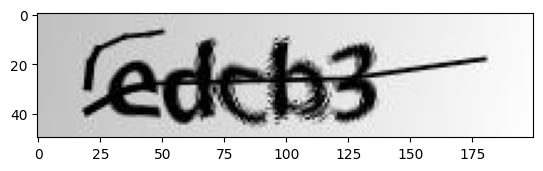

In [89]:
mistake_image_fp = os.path.join(data_path, "val/", mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [90]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.9953271028037384
0.8130841121495327


## Save Model

In [91]:
torch.save(crnn, 'resnet18_model.pth')

In [92]:
model = torch.load('resnet18_model.pth')

## Check the saved model

  0%|          | 0/1 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


,actual,prediction,predictionCorrected
0,2b827,22bb882277,2b827


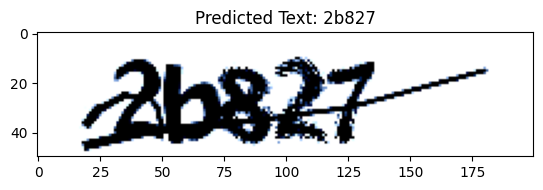

In [114]:
sampleset = CAPTCHADataset("./data/sample")
sample_loader = DataLoader(sampleset, batch_size=16, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(sample_loader, leave=True):
        text_batch_logits = model(image_batch.to(device))
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred


plt.imshow(image_batch[0].permute(1, 2, 0))
plt.title(f"Predicted Text: {text_batch[0]}")
df["predictionCorrected"] = df['prediction'].apply(correct_prediction)
df.head()